# 3. More on images

In the previous chapter we have seen how images can be imported in Python as Numpy arrays and what kind of operations we can do with these arrays. Here we give more information on some technical aspects of working with images.

## Displaying images

There are several libraries that allow you to display images. Here we mainly use Matplotlib which you can use for other purposes and which is also used as basis for other libraries. Until now we have learned to import the library:

In [1]:
import matplotlib.pyplot as plt

And we have seen how we can display an image with ```imshow```:

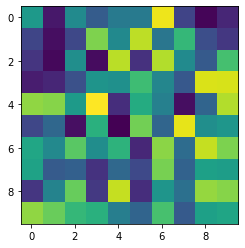

In [5]:
import numpy as np
plt.imshow(np.random.randint(0,255,(10,10)));

The above way of creating a figure is a sort of shortcut. The "correct" way of creating a figure that you should use if you want more control over it is:

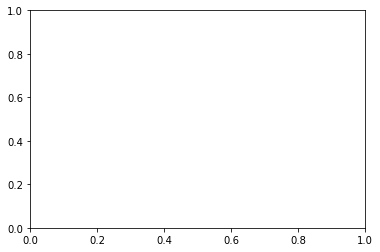

In [6]:
fig, ax = plt.subplots()

As you can see, the above commmand ```plt.subplots()``` creates an empty figure and returns two variables ```fig``` and ```ax```. ```fig``` is the *entire figure* which potentially could contain multiple parts. The ```ax``` variable represents the plot itself. Now instead of using ```plt.imshow``` we can use ```ax.imshow``` and finely control the rendering:

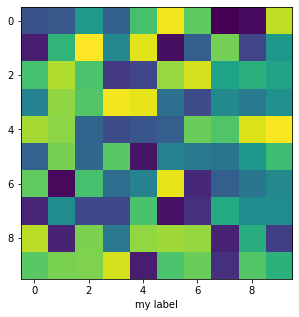

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(np.random.randint(0,255,(10,10)));
ax.set_xlabel('my label');

Above we have used:
- an optional parameter ```figsize``` with which we can set the size of the figure
- added an axis label using the ```set_xlabel``` method on ```ax```

You can decide on the formatting of your plots in the tiniest detail with Matplotlib. In this course, we don't explore all these possibilities but if you are interested you can find more information in this other online course: https://guiwitz.github.io/DAVPy/Readme.html. The only thing that we will use is sometimes the ```figsize``` option to adjust the figure size.

## Multi-dimensional images

When learning about images as arrays, we used an image that was imported as a 2D array:

In [15]:
import skimage.io
image = skimage.io.imread('https://cildata.crbs.ucsd.edu/media/images/13901/13901.tif')

In [16]:
image.shape

(1024, 1360)

However, very often in microscopy we are using multi-dimensional images: time-lapses, multi-channel, volumes etc. In those cases the imported arrays are not 2 but N-dimensional. Let's for example import the following image:

In [17]:
image_rgb = skimage.io.imread('https://github.com/guiwitz/PyImageCourse_beginner/raw/master/images/46658_784_B12_1.tif')

In [18]:
image_rgb.shape

(2048, 2048, 3)

The shape of this image has now three values: rows, columns and an additional one. Here this last channel corresponds the multiple channels. We can plot the image to confirm this:

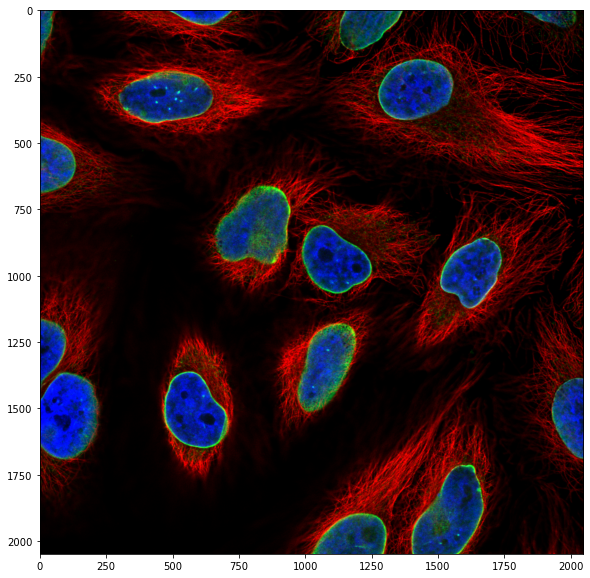

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(image_rgb);

### Splitting channels

When using other software such as ImageJ a very common first step in a processing pipeline is to split the image into separate channels so that they can be processed individually. There is no "splitting function" here, but since we are dealing with an array, we can simply **slice** the array and select only one of the channels. If we want the first channel we need:
- all rows of the first dimension: ```:```
- all columns of the second dimension: ```:```
- the first channel of the third dimension: ```0```

In [10]:
image_channel1 = image_rgb[:, : , 0]

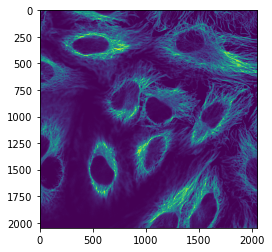

In [13]:
plt.imshow(image_channel1);

And we can repeat this for all channels:

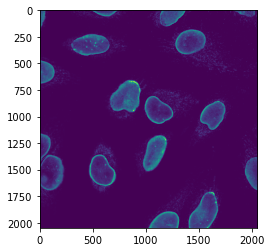

In [14]:
image_channel2 = image_rgb[:, : , 1]
plt.imshow(image_channel2);

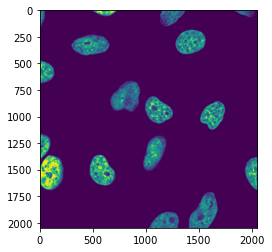

In [16]:
image_channel3 = image_rgb[:, : , 2]
plt.imshow(image_channel3);

It can be that you will work with even higher-dimensional images. For example if you have a volume acquired in multiple channels you will have four dimensions: rows, columns, planes, channels.

If the standard scikit-image importer is not sufficient because you are working with an unrecognized format we recommend to have a look at the [AICSImageIO](https://allencellmodeling.github.io/aicsimageio/) package. It is not as straightforward to use as the simple ```imread``` but more powerful.

## Image histogram

Another very common task is to look at the distribution of pixel intensities in the form of a histogram, i.e. count how many times each pixel value (or range) appears in an image and display it a a bar. This allows to get a quick estimate of the intensities present in an image and to check for problems like saturation.

We have already seen that we could use Matplotlib's ```imshow``` function to display an image. Now we look at a second plotting function from that library which generates such a histogram ```plt.hist()```. We want to compute the histogram on **all pixels** and for that we cannot use our 2D image as input. We first need to **flatten** the image into one long series of number. This can be done with the ```ravel()``` method of the array:

In [24]:
image_channel1.shape

(2048, 2048)

The expected length of the unfolded image is:

In [27]:
2048 * 2048

4194304

In [28]:
image_channel1.ravel().shape

(4194304,)

Now we can pass this unfolded version of the image to the histogram function:

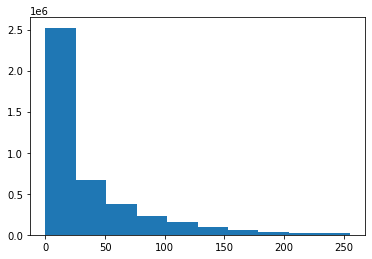

In [29]:
plt.hist(image_channel1.ravel());

Here we see that we have a lot of background pixels (large bin at low values) but we luckily don't observe saturation, which would appear as one large bin on the right.

## Image types

In the above historgram we see that our maximum value is around 250, actually it is:

In [30]:
image_channel1.max()

255

Has this number any meaning? Let's look at what type of numbers we have inside the array:

In [31]:
image_channel1.dtype

dtype('uint8')

The above output indicates that we have an unsigned 8-bit integer image. This means that the pixels can take all possible values between 0 and $2^8 = 256$ (not included). This is the reason why the maximum possible value in our array is 255.

We have to be somewhat careful with this. Let's look at a small portion of the image by cropping it:

In [32]:
image_channel1[0:3, 0:3]

array([[13, 15, 22],
       [22, 29, 36],
       [14, 22, 25]], dtype=uint8)

Now let us do some operation: we want to remove an estimated background that we here arbitrarily set at 10. We now have to subtract this value from each pixel in the image, so we do:

In [33]:
image_channel1[0:3, 0:3] - 10

array([[ 3,  5, 12],
       [12, 19, 26],
       [ 4, 12, 15]], dtype=uint8)

All is fine, the value 10 has been subtracted from each pixel. Now let's imagine that the background has been estimated to 30:

In [38]:
image_channel1[0:3, 0:3] - 30

array([[239, 241, 248],
       [248, 255,   6],
       [240, 248, 251]], dtype=uint8)

Something strange happened: for example the original value 36 has indeed become 6, but the value 13 has become 239 ?!

The type of our array is 8 bit. This means that it can **only** take values between 0-255. So when we compute 13-30, we **cannot obtain a negative value**. What happens is that instead we subtract first 13, reach the value 0, and then essentially end-up at the other end of the possible range of values which which is 255 and then remove additionally 17 and end-up with the value 239.

We can see the strange result of such an operation by plotting:

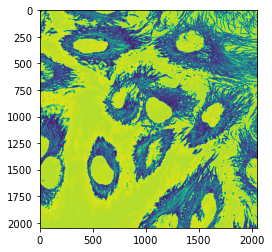

In [40]:
plt.imshow(image_channel1-30);

What can we do to fix this problem ? We have to change the type of our image so that it can accomodate this mathematical operation. For example we can turn it into a float image. For this we use the ```astype``` function:

In [42]:
import numpy as np

image_channel1_float = image_channel1.astype(np.float16)

In [45]:
image_channel1_float[0:3, 0:3]

array([[13., 15., 22.],
       [22., 29., 36.],
       [14., 22., 25.]], dtype=float16)

In [46]:
image_channel1_float[0:3, 0:3] - 30

array([[-17., -15.,  -8.],
       [ -8.,  -1.,   6.],
       [-16.,  -8.,  -5.]], dtype=float16)